### **SETTING UP DATA AND INPUTS**

In [2]:
#INITIAL SETUP

#Check that everything we need is installed
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install split_folders tqdm

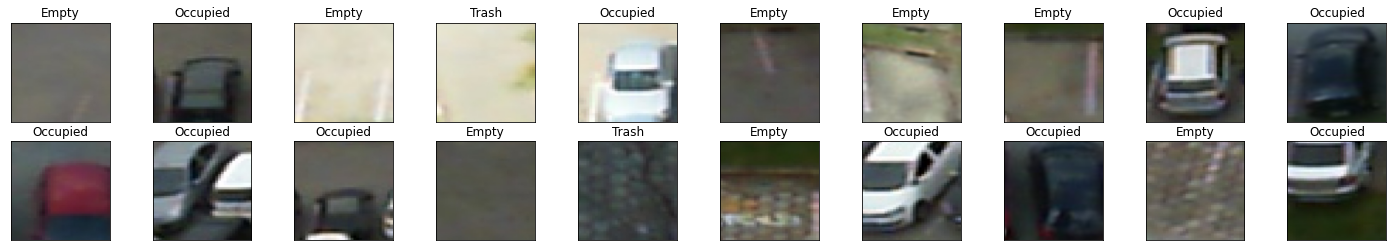

In [ ]:
#Upload data from Google Drive 

# Location of file on drive
file_path = '/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/Segmented'

# Transform Settings - from sample code
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# Load data from file path
dataset = torchvision.datasets.ImageFolder(file_path, transform=transform)

# Prepare Dataloader - from sample code
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1, 
                                          shuffle=True)

# Verification Step - from sample code
dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() 

classes = ['Empty', 'Occupied','Trash']

# Plot the images in the batch - from sample code
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(classes[labels[i]])

### **TRANSFER LEARNING**

In [4]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)
ALNC = alexnet.features

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Save Features to Folder (assumes code from 1. has been evaluated)
alexnet = torchvision.models.alexnet(pretrained=True)

# location on Google Drive
master_path = '/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/Features'

# Prepare Dataloader 
batch_size = 1 
num_workers = 1
data_ft_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes = ['Empty','Occupied','Trash']

# save features to folder as tensors
n = 0
for img, label in data_ft_loader:
  print(n)
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  folder_name = master_path + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
  n += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
# Load Tensor Files (features) from folder

# Load features
#master_path = '/content/drive/My Drive/EngSci Year3/APS360/APS360 - Group 21/05 Data Processing/Sliding Window/Features'
master_path = '/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/Features'
dataset_ft = torchvision.datasets.DatasetFolder(master_path, loader=torch.load, extensions=('.tensor'))

# Prepare Dataloader
batch_size = 32
num_workers = 1
feature_loader = torch.utils.data.DataLoader(dataset_ft, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([32, 256, 6, 6])
torch.Size([32])


In [ ]:
#Break up features into training, validation, and testing

#SPLITTING
import splitfolders

splitfolders.ratio(master_path, output ='features', seed = 1337, ratio = (0.8,0.1,0.1))

Copying files: 1210 files [01:28, 13.63 files/s]


In [ ]:
#Prepare data loaders - train, val, test

data_ft_dir = '/content/features/'
#data_ft_dir = '/content/content/features/'
train_ft_dir = os.path.join(data_ft_dir, 'train/')
val_ft_dir = os.path.join(data_ft_dir, 'val/')
test_ft_dir = os.path.join(data_ft_dir, 'test/')

train_ft_data = torchvision.datasets.DatasetFolder(train_ft_dir, loader=torch.load, extensions=('.tensor'))
val_ft_data = torchvision.datasets.DatasetFolder(val_ft_dir, loader=torch.load, extensions=('.tensor'))
test_ft_data = torchvision.datasets.DatasetFolder(test_ft_dir, loader=torch.load, extensions=('.tensor'))

#Print out data stats 
print('Number of training features: ', len(train_ft_data))
print('Number of validation features: ', len(val_ft_data))
print('Number of testing features: ', len(test_ft_data))

#Prepare data loaders
train_ft_loader = torch.utils.data.DataLoader(train_ft_data, batch_size=32, num_workers=1 , 
                                           shuffle=True)
val_ft_loader = torch.utils.data.DataLoader(val_ft_data, batch_size=32, num_workers=1 , 
                                           shuffle=True)
test_ft_loader = torch.utils.data.DataLoader(test_ft_data, batch_size=32, num_workers=1, 
                                           shuffle=True)

Number of training features:  966
Number of validation features:  120
Number of testing features:  124


In [5]:
#ANN Arcitecture

torch.manual_seed(1)

class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.name = "ANNClassifier"

        #Takes input with dimensions 256 x 6 x 6 - size of feature data
        self.fc1 = nn.Linear(256 * 6 * 6, 300)   
        self.fc2 = nn.Linear(300, 3) #Changed 9 to 3

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #Flatten the feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model=ANNClassifier()

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def get_an_accuracy(model, train=False):
    if train:
        data_loader = train_ft_loader
    else:
        data_loader = val_ft_loader
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
import time 

def train(model, train_loader, val_loader, batch_size, num_epochs, lr):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    iters, losses, train_acc, val_acc = [], [], [], []

    # Training
    n = 0 
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        Mini_batch_total = 0
        for imgs, labels in iter(train_loader):
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
          
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            ##### Mini_batch Accuracy ##### 
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            Mini_batch_total = imgs.shape[0]
            train_acc.append((mini_batch_correct / Mini_batch_total))

            #Save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)               # compute *average* loss
            val_acc.append(get_an_accuracy(model, train = False))  # compute validation accuracy
            n += 1
            mini_b += 1
            print("Iteration: ",n,'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))


        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


    end_time= time.time()
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Training")
    plt.plot(iters, val_acc, label="Test")    
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.legend(loc='best')
    plt.show()

    train_acc.append(get_an_accuracy(model, train = True))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Test Accuracy: {}".format(val_acc[-1]))
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
use_cuda = True

model = ANNClassifier()
ALNC = alexnet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_ft_loader, test_ft_loader, batch_size=64, num_epochs=15,lr=1e-4)

CUDA is not available.  Training on CPU ...
Iteration:  1 Progress:   0.01  % Time Elapsed:   0.58 s 
Iteration:  2 Progress:   0.01  % Time Elapsed:   0.97 s 
Iteration:  3 Progress:   0.02  % Time Elapsed:   1.39 s 
Iteration:  4 Progress:   0.03  % Time Elapsed:   1.78 s 
Iteration:  5 Progress:   0.03  % Time Elapsed:   2.17 s 
Iteration:  6 Progress:   0.04  % Time Elapsed:   2.59 s 
Iteration:  7 Progress:   0.05  % Time Elapsed:   2.99 s 
Iteration:  8 Progress:   0.06  % Time Elapsed:   3.41 s 
Iteration:  9 Progress:   0.06  % Time Elapsed:   3.81 s 
Iteration:  10 Progress:   0.07  % Time Elapsed:   4.21 s 
Iteration:  11 Progress:   0.08  % Time Elapsed:   4.62 s 
Iteration:  12 Progress:   0.08  % Time Elapsed:   5.02 s 
Iteration:  13 Progress:   0.09  % Time Elapsed:   5.42 s 
Iteration:  14 Progress:   0.10  % Time Elapsed:   5.81 s 
Iteration:  15 Progress:   0.10  % Time Elapsed:   6.20 s 
Iteration:  16 Progress:   0.11  % Time Elapsed:   6.61 s 
Iteration:  17 Progre

In [ ]:
# #Save the model weights
# save_dict = model.state_dict()
# save_path='/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/model.pt'
# torch.save(save_dict, save_path)

#TESTING A SINGLE SAMPLE

In [6]:
model = ANNClassifier()
#Run this code to upload the model weights
save_path='/content/drive/My Drive/EngSci Year3/APS360/APS360 - Group 21/05 Data Processing/Sliding Window/model.pt'
#save_path='/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/model.pt'
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

a)Using the features

In [ ]:
batch_size = 1


train_ft_loader = torch.utils.data.DataLoader(train_ft_data, batch_size=batch_size, num_workers=1 , 
                                           shuffle=True)
val_ft_loader = torch.utils.data.DataLoader(val_ft_data, batch_size=batch_size, num_workers=1 , 
                                           shuffle=True)
test_ft_loader = torch.utils.data.DataLoader(test_ft_data, batch_size=batch_size, num_workers=1, 
                                           shuffle=True)

In [ ]:
ALNC = alexnet.features

for imgs, labels in iter(train_ft_loader):
      out = model(imgs)  
      pred = out.max(1, keepdim=True)[1]
      mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
      print(mini_batch_correct)
      print(pred)
      print(labels.view_as(pred))
      break

1
tensor([[1]])
tensor([[1]])


b)Using my own cropped images

In [8]:
# Location of file on drive
#my_path = '/content/drive/My Drive/APS360 - Group 21/07 Primary Model/test'
#my_path = '/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Segmentation Test'
my_path = '/content/drive/My Drive/EngSci Year3/APS360/APS360 - Group 21/05 Data Processing/Sliding Window/Segmented10'
#my_path = '/content/drive/My Drive/APS360 - Group 21/05 Data Processing/Sliding Window/Segmented4'


# Transform Settings - from sample code
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# Load data from file path
mydataset = torchvision.datasets.ImageFolder(my_path, transform=transform)

# Prepare Dataloader - from sample code
my_loader = torch.utils.data.DataLoader(mydataset, batch_size=1, num_workers=1, 
                                          shuffle=True)

print(len(my_loader)+1)

# for images, label in iter(my_loader):
#   image = images.numpy() 
#   # Plot the images in the batch - from sample code
#   fig = plt.figure(figsize=(25, 4))
#   ax = fig.add_subplot(2, 20/2, 1, xticks=[], yticks=[])
#   plt.imshow(np.transpose(image[0], (1, 2, 0)))

106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


total number of cars 43


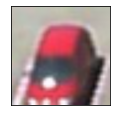

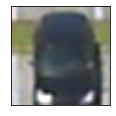

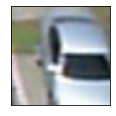

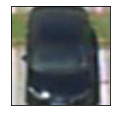

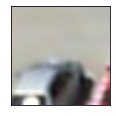

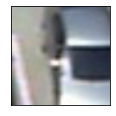

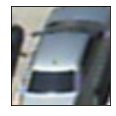

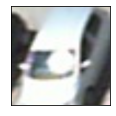

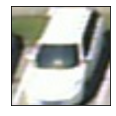

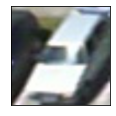

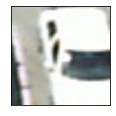

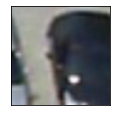

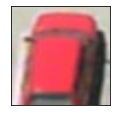

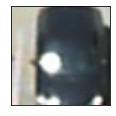

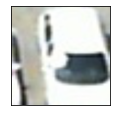

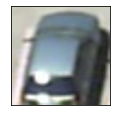

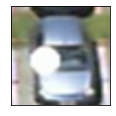

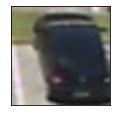

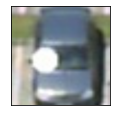

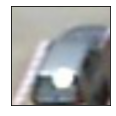

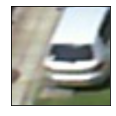

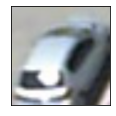

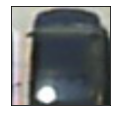

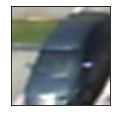

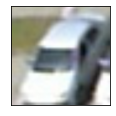

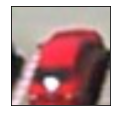

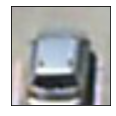

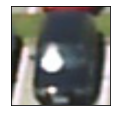

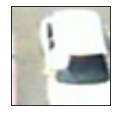

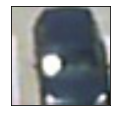

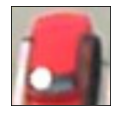

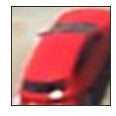

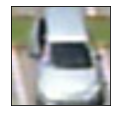

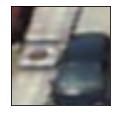

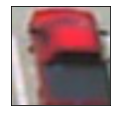

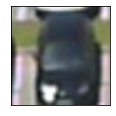

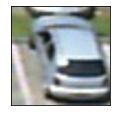

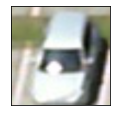

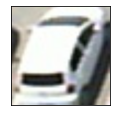

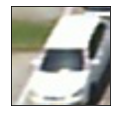

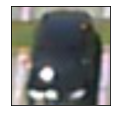

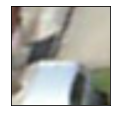

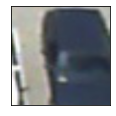

In [9]:
ALNC = alexnet.features
num_cars=0
for images, trash in iter(my_loader):
      imgs=ALNC(images)
      out = model(imgs)  
      pred = out.max(1, keepdim=True)[1]
      
      if(pred==1):
        num_cars+=1
        image = images.numpy() 
        # Plot the images in the batch - from sample code
        fig = plt.figure(figsize=(25, 4))
        ax = fig.add_subplot(2, 20/2, 1, xticks=[], yticks=[])
        plt.imshow(np.transpose(image[0], (1, 2, 0)))

      # print(pred)
      # image = images.numpy() 
      # # Plot the images in the batch - from sample code
      # fig = plt.figure(figsize=(25, 4))
      # ax = fig.add_subplot(2, 20/2, 1, xticks=[], yticks=[])
      # plt.imshow(np.transpose(image[0], (1, 2, 0)))

print("total number of cars", num_cars)
     

In [ ]:
#https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0

In [ ]:
# #IGNORE this code

# !zip -r /content/features.zip /content/features

# from google.colab import files
# files.download("/content/features.zip")


In [ ]:
# #once you upload the zip you just unzip it
# !unzip features.zip 
